# Matrix Factorization Collaborative Filtering

Collaborative filtering considers users’ opinion on different products and recommends the best products based on the products’ previous rankings and the opinion of other similar types of users. 

Here we focus on non-probablistic collaborative filtering algorithms, which can be divided to two categories: **memory-based** and **model-based**. 

In the last notebook, we showed how item-based algorithm is not good for sparseness and scaling. Model-based algorithm involves **matrix factorization** and **dimensionality reduction**.

Matrix factorization means decomposing the user-item matrix into two lower smaller matrices: user matrix and item matrix. Users and products will then be described by the **latent factors**.

This notebook implements matrix factorization using **Singular Vector Decomposition (SVD)**. 

### import requirements

In [1]:
# import library
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from collections import Counter

Source: [surprise documentation](https://surprise.readthedocs.io/en/stable/getting_started.html)

In [2]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split

In [3]:
# load data
df = pd.read_csv('../ratings_item0.csv', index_col=0)
df.head(3)

,uid,bid,rating
10,276746,0425115801,0
11,276746,0449006522,0
12,276746,0553561618,0


In [4]:
df.shape

(456182, 3)

In [5]:
num_users = len(set(df['uid']))
num_books = len(set(df['bid']))
print(f'There are {num_users} users and {num_books} books in this dataset.')

There are 13808 users and 18318 books in this dataset.


### data loading

In [6]:
reader = Reader(rating_scale=(1,10))

In [7]:
data = Dataset.load_from_df(df[['uid', 'bid', 'rating']], reader)

## Parameter Search
`GridSearchCV(algo_class, param_grid, measures=[u'rmse', u'mae'], cv=None, refit=False, return_train_measures=False)`

`RandomizedSearchCV`

Parameters
- `param_grid`

        param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [2, 3],
              'sim_options': {'name': ['msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [False]}
              }

Attributes
- `best_estimmator`
- `best_score`
- `best_params`
- `cv_results`
        results_df = pd.DataFrame.from_dict(gs.cv_results)
- ...

In [8]:
# param_grid = {
#     #'n_factors': [3, 5, 10, 50],
#     #'n_epochs': [5, 10, 20], 
#     'lr_all': [0.002, 0.005, 0.01],
#     'reg_all': [0.2, 0.4, 0.6]
# }

In [9]:
# gs = GridSearchCV(SVD, 
#                   param_grid, 
#                   measures=['rmse', 'mae'], 
#                   cv=3)

In [10]:
# gs.fit(data)

In [11]:
# # best RMSE score
# print(gs.best_score)

In [12]:
best_score = {'rmse': 3.4388163231541147, 'mae': 2.937120732531161}
print(best_score)

{'rmse': 3.4388163231541147, 'mae': 2.937120732531161}


In [13]:
# # combination of parameters that gave the best RMSE score
# print(gs.best_params['rmse'])

In [14]:
best_params = {'lr_all': 0.005, 'reg_all': 0.4}
print(best_params)

{'lr_all': 0.005, 'reg_all': 0.4}


In [15]:
# results_df = pd.DataFrame.from_dict(gs.cv_results)
# results_df.sort_values(by='rank_test_rmse')[:3]

In [16]:
#results_df.to_csv('svd_results.csv')

## evaluation

In [17]:
# results_df = results_df[
#     ['split0_test_rmse', 'rank_test_rmse', 
#      'params', 'param_lr_all', 'param_reg_all']]

In [18]:
# results_df = pd.concat([
#     results_df.drop(['param_lr_all'], axis=1), 
#     results_df['param_lr_all'].apply(pd.Series)
#     ], axis=1)

In [19]:
# results_df = pd.concat([
#     results_df.drop(['param_reg_all'], axis=1), 
#     results_df['param_reg_all'].apply(pd.Series)
#     ], axis=1)

In [20]:
# results_df.to_csv('svd_results_cleaned.csv')

In [21]:
results_df = pd.read_csv('svd_results_cleaned.csv', index_col=0)
results_df.columns = ['split0_test_rmse', 'rank_test_rmse', 'params', 'lr_all', 'reg_all']

In [22]:
results_df.sort_values(by='rank_test_rmse')[:5]

,split0_test_rmse,rank_test_rmse,params,lr_all,reg_all
4,3.435843,1,"{'lr_all': 0.005, 'reg_all': 0.4}",0.005,0.4
8,3.448499,2,"{'lr_all': 0.01, 'reg_all': 0.6}",0.010,0.6
0,3.449544,3,"{'lr_all': 0.002, 'reg_all': 0.2}",0.002,0.2
5,3.451672,4,"{'lr_all': 0.005, 'reg_all': 0.6}",0.005,0.6
7,3.458560,5,"{'lr_all': 0.01, 'reg_all': 0.4}",0.010,0.4


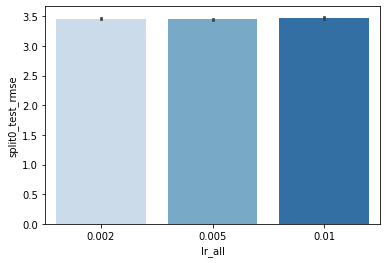

In [23]:
sns.barplot(x=results_df['lr_all'], y=results_df['split0_test_rmse'], palette='Blues')

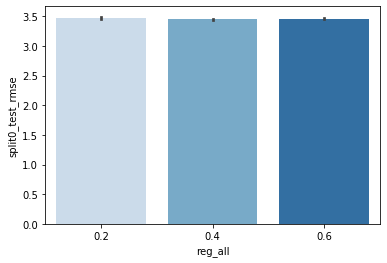

In [24]:
sns.barplot(x=results_df['reg_all'], y=results_df['split0_test_rmse'], palette='Blues')

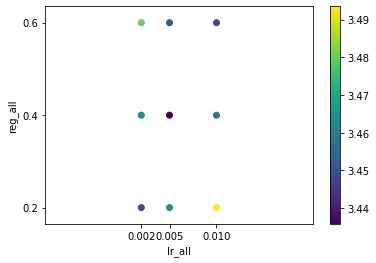

In [25]:
plt.scatter(x=results_df['lr_all'], 
            y=results_df['reg_all'],
            c=results_df['split0_test_rmse'])

plt.xticks([0.002, 0.005, 0.01])
plt.yticks([0.2, 0.4, 0.6])
plt.xlabel('lr_all')
plt.ylabel('reg_all')
plt.colorbar()

## How to get top-N recommendations for each user
Source: [documentation](https://surprise.readthedocs.io/en/stable/FAQ.html)

We first train an SVD algorithm on the whole dataset, and then predict all the ratings for the pairs (user, item) that are not in the training set. We then retrieve the top-10 prediction for each user.

In [26]:
def get_top_n(predictions, n=10):
   # map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [27]:
trainset, testset = train_test_split(data, test_size=.25)

In [28]:
algo = SVD(lr_all=0.005, reg_all=0.4)

In [29]:
predictions = algo.fit(trainset).test(testset)

In [30]:
test_df = pd.DataFrame(testset, columns=['uid', 'bid', 'rating'])
test_df.head(3)

,uid,bid,rating
0,134835,0684801043,0.0
1,37227,0804115613,10.0
2,131046,0345339738,10.0


accuracy = whether the top items that the user bought is in the top items we recommended. 

In [34]:
n = 10
top_n = get_top_n(predictions, n=n)
accuracy = []

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    bought = set(test_df[test_df['uid']==uid].sort_values(
        by='rating', ascending=False)[:n]['bid'])
    predicted = set([bid for bid, rating in user_ratings])
    rate = len(bought.intersection(predicted)) / len(predicted)
    accuracy.append(rate)
print(sum(accuracy)/len(accuracy))

0.9188674774917074


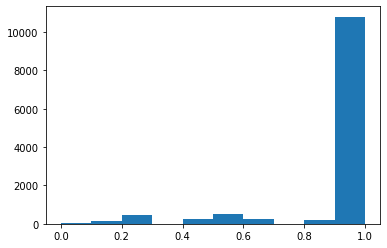

In [35]:
plt.hist(accuracy)
plt.show()

In [36]:
n = np.arange(1,21,1)
avg_accuracy = []

for i in n:
    top_n = get_top_n(predictions, n=i)
    accuracy = []
    
    for uid, user_ratings in top_n.items():
        bought = set(test_df[test_df['uid']==uid].sort_values(
            by='rating', ascending=False)[:i]['bid'])
        predicted = set([bid for bid, rating in user_ratings])
        rate = len(bought.intersection(predicted)) / len(predicted)
        accuracy.append(rate)
    
    avg_accuracy.append(sum(accuracy)/len(accuracy))

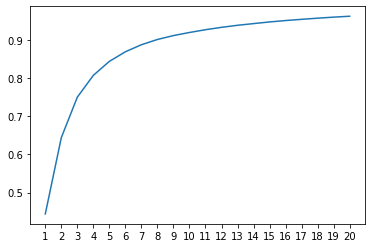

In [37]:
plt.plot(avg_accuracy)
plt.xticks(np.arange(0,20,1),n)
plt.show()

accuracy = whether the top items that the user bought matched element-wise with the top items we recommended

In [45]:
n = 10
top_n = get_top_n(predictions, n=n)
accuracy = []

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    bought = list(test_df[test_df['uid']==uid].sort_values(
        by='rating', ascending=False)[:n]['bid'])
    predicted = list([bid for bid, rating in user_ratings])
    #rate = len(bought.intersection(predicted)) / len(predicted)
    count = 0
    for l1,l2 in zip(bought,predicted):
        if l1 == l2:
            count+=1
    rate = count/len(predicted)
    accuracy.append(rate)
print(sum(accuracy)/len(accuracy))

0.4263331666052413


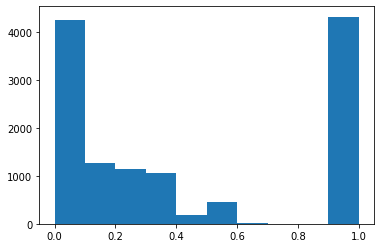

In [46]:
plt.hist(accuracy)
plt.show()

In [47]:
n = np.arange(1,21,1)
avg_accuracy = []

for i in n:
    top_n = get_top_n(predictions, n=i)
    accuracy = []
    
    for uid, user_ratings in top_n.items():
        bought = set(test_df[test_df['uid']==uid].sort_values(
            by='rating', ascending=False)[:i]['bid'])
        predicted = set([bid for bid, rating in user_ratings])
        #rate = len(bought.intersection(predicted)) / len(predicted)
        count = 0
        for l1,l2 in zip(bought,predicted):
            if l1 == l2:
                count+=1
        rate = count/len(predicted)
        accuracy.append(rate)
    avg_accuracy.append(sum(accuracy)/len(accuracy))

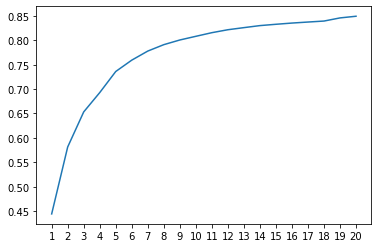

In [48]:
plt.plot(avg_accuracy)
plt.xticks(np.arange(0,20,1),n)
plt.show()